In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    classification_report,
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix
)
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
# Load the CSV
clinical_df = pd.read_csv("/home/val/workspaces/histotab/data/raw/msk_luad_all_genes/luad_mskcc_2020_clinical_data.tsv", sep="\t", index_col=0)
gene_df = pd.read_csv("/home/val/workspaces/histotab/data/raw/msk_luad_all_genes/alterations_across_samples.tsv", sep="\t", index_col=0)
gene_enrichement_df = pd.read_csv("/home/val/workspaces/histotab/data/raw/msk_luad_all_genes/MSigDB_Hallmark_2020_table.csv", sep="\t", index_col=0)

In [3]:
col_to_keep = [c for c in gene_df.columns if ":" not in c]
gene_df = gene_df[col_to_keep]

if gene_df.isna().any().any():
    raise ValueError("DataFrame contains NaN values please handle them before mapping.")

# Define a mapping function
def classify_driver_mutation(val):
    if val == "no alteration":
        return 0
    elif val == "not profiled":
        return np.nan
    elif "driver" in val.lower() or "oncogene" in val.lower():
        return 1
    else:
        return 0

def classify_mutation(val):
    if val == "no alteration":
        return 0
    elif val == "not profiled":
        return np.nan
    return 1



# Apply the mapping to gene columns only (exclude non-gene metadata columns)
non_gene_cols = ["Study ID", "Sample ID", "Patient ID", "Altered"]
gene_cols = [col for col in gene_df.columns if col not in non_gene_cols]

# Apply mapping to gene columns
gene_df[gene_cols] = gene_df[gene_cols].map(classify_driver_mutation)
# gene_df[gene_cols] = gene_df[gene_cols].map(classify_mutation)


In [4]:
clinical_df.columns

Index(['Patient ID', 'Sample ID', 'Age At Surgery', 'Cancer Type',
       'Cancer Type Detailed', 'Clinical Nodal Status', 'CT Size',
       'Diffusion lung capacity for carbon monoxide', 'FEV1', 'FGA Facets',
       'Fraction Genome Altered', 'Mutation Count', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status',
       'Pathologic Stage', 'Pathologic Nodal Status',
       'Predominant Histologic Subtype', 'Relapse Free Status (Months)',
       'Relapse Free Status', 'Number of Samples Per Patient', 'Sex',
       'Smoking History', 'Person Cigarette Smoking History Pack Year Value',
       'Subtype Group', 'Standardized uptake values ', 'Tumor Mutation Burden',
       'TMB (nonsynonymous)'],
      dtype='object')

In [5]:
# target_col = "Predominant Histologic Subtype"
target_col = "Subtype Group"
clinical_col = [
    "Sample ID",
    "Patient ID",
    target_col,
]
clinical_df = clinical_df[clinical_col]

In [6]:
def merge_gene_clinical(gene_df, clinical_df):
    clinical_df = clinical_df.copy()
    clinical_df = clinical_df.sort_values(by=["Sample ID"], inplace=False)
    clinical_df = clinical_df.drop_duplicates(subset=["Patient ID"], keep="first", inplace=False)

    gene_df = gene_df.drop(columns=["Altered",  "Patient ID"])
    gene_df = gene_df.set_index("Sample ID")
    clinical_df = clinical_df.set_index("Sample ID")
    clinical_df  = clinical_df.join(gene_df, how="inner")
    return clinical_df

In [7]:
final_df = merge_gene_clinical(gene_df, clinical_df)
final_df.head()

,Patient ID,Subtype Group,DICER1,NUP93,TEK,CDK12,RB1,ARAF,PREX2,KNSTRN,...,CBL,FLCN,RPS6KA4,POLE,SPRED1,POLD1,GNA11,VHL,MAPK3,MAPK1
Sample ID,,,,,,,,,,,,,,,,,,,,,
P-0000219-T01-IM3,P-0000219,Micropapillary/ Solid,0,NaN,NaN,0,0,0,NaN,NaN,...,0,0,0,0,NaN,NaN,0,0,NaN,0
P-0000280-T01-IM3,P-0000280,Acinar/ Papillary,0,NaN,NaN,0,0,0,NaN,NaN,...,0,0,0,0,NaN,NaN,0,0,NaN,0
P-0000627-T02-IM5,P-0000627,Acinar/ Papillary,0,0.0,NaN,0,0,0,NaN,NaN,...,0,0,0,0,NaN,0.0,0,0,0.0,0
P-0000867-T01-IM3,P-0000867,Acinar/ Papillary,0,NaN,NaN,0,0,0,NaN,NaN,...,0,0,0,0,NaN,NaN,0,0,NaN,0
P-0001944-T01-IM3,P-0001944,Acinar/ Papillary,0,NaN,NaN,0,0,0,NaN,NaN,...,0,0,0,0,NaN,NaN,0,0,NaN,0


In [8]:
# Drop genes with 'not profiled'
final_df = final_df.dropna(axis="columns")
final_df.head()

,Patient ID,Subtype Group,DICER1,CDK12,RB1,ARAF,AKT3,MYC,AKT1,AKT2,...,ERCC2,ERCC3,KRAS,CBL,FLCN,RPS6KA4,POLE,GNA11,VHL,MAPK1
Sample ID,,,,,,,,,,,,,,,,,,,,,
P-0000219-T01-IM3,P-0000219,Micropapillary/ Solid,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0000280-T01-IM3,P-0000280,Acinar/ Papillary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0000627-T02-IM5,P-0000627,Acinar/ Papillary,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
P-0000867-T01-IM3,P-0000867,Acinar/ Papillary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0001944-T01-IM3,P-0001944,Acinar/ Papillary,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
pathway_mappings = {}
for pathway in gene_enrichement_df.index:
    gene_list = gene_enrichement_df.loc[pathway, "Genes"].split(";")
    gene_list = [gene_id for gene_id in gene_list if gene_id in final_df.columns]
    pathway_mappings[pathway] = gene_list

In [10]:
canonical_pathways = {
    "RTK_RAS": [
        "EGFR", "ERBB2", "ERBB3", "ERBB4", "MET", "PDGFRA", "FGFR1", "FGFR2", "FGFR3", "FGFR4",
        "KIT", "IGF1R", "RET", "ROS1", "ALK", "FLT3", "NTRK1", "NTRK3", "JAK2", "CBL", "ERRFI1",
        "ABL1", "SOS1", "KRAS", "HRAS", "NRAS", "RIT1", "NF1", "RASA1", "PTPN11", "MAPK1",
        "MAP2K1", "MAP2K2", "RAF1", "BRAF", "ERF", "RAC1"
    ],
    "NRF2": [
        "KEAP1", "CUL3", "NFE2L2"
    ],
    "PI3K": [
        "PTEN", "INPP4B", "PIK3CA", "PIK3CB", "PIK3R1", "PIK3R2", "AKT1", "AKT2", "AKT3",
        "PPP2R1A", "STK11", "TSC1", "TSC2", "RHEB", "RICTOR", "MTOR", "RPTOR"
    ],
    "TGF_beta": [
        "TGFBR1", "TGFBR2", "ACVR2A", "ACVR1B", "SMAD2", "SMAD3", "SMAD4"
    ],
    "TP53": [
        "CDKN2A", "MDM2", "MDM4", "TP53", "ATM", "CHEK2", "RPS6KA3"
    ],
    "Cell_Cycle": [
        "CDKN1A", "CDKN1B", "CDKN2A", "CDKN2B", "CCNE1", "CCND1", "CCND2", "CCND3",
        "CDK2", "CDK4", "CDK6", "RB1", "E2F1", "E2F3"
    ],
    "WNT": [
        "SFRP1", "SFRP2", "SFRP5", "WIF1", "RNF43", "ZNRF3", "FZD5", "LRP5", "LRP6",
        "DKK1", "DKK4", "GSK3B", "APC", "CTNNB1", "AXIN1", "AXIN2", "AMER1",
        "TCF7", "TCF7L1", "TCF7L2", "TLE1", "TLE4"
    ],
    "MYC": [
        "MYC", "MYCN", "MYCL", "MAX", "MGA", "MXD1", "MXD3", "MXD4",
        "MNT", "MLX", "MLXIP", "MLXIPL"
    ],
    "HIPPO": [
        "DCHS1", "FAT1", "FAT2", "FAT3", "FAT4", "TAOK1", "TAOK2", "TAOK3",
        "SAV1", "STK3", "STK4", "MOB1A", "MOB1B", "NF2", "WWC1", "CRB1", "YAP1",
        "TAZ", "TEAD1", "PTPN14", "CSNK1E", "CSNK1D", "TEAD2"
    ],
    "NOTCH": [
        "JAG2", "ARRDC1", "FBXW7", "NOV", "CNTN6", "NOTCH1", "NOTCH2", "NOTCH3", "NOTCH4",
        "DNER", "PSEN2", "CUL1", "MAML3", "KAT2B", "CREBBP", "EP300", "HESX1", "HEY1",
        "HEY2", "NCOR1", "NCOR2", "SPEN", "KDM5A"
    ]
}


In [11]:
def get_pathway_df(pathway_dict, final_df):
    pathway_df = pd.DataFrame(index=final_df.index)
    for pathway, genes in pathway_dict.items():
        genes = [gene for gene in genes if gene in final_df.columns]
        pathway_df[pathway] = final_df[genes].sum(axis=1).astype(np.float32)
    return pathway_df

In [12]:
pathway_df = get_pathway_df(canonical_pathways, final_df)

In [13]:
pathway_list = [
    "E2F Targets",
    "PI3K/AKT/mTOR  Signaling",
    "UV Response Dn",
    "G2-M Checkpoint",
    "Apoptosis",
    "TNF-alpha Signaling via NF-kB",
    # "p53 Pathway",
    # "Apical Junction",
    # "Allograft Rejection",
    # "TGF-beta Signaling",
    # "Wnt-beta Catenin Signaling",
    # "KRAS Signaling Up",
    # "Interferon Gamma Response",
    # "IL-2/STAT5 Signaling",
    # "Hypoxia",
    # "Hedgehog Signaling",
]

In [14]:
pathway_df[target_col] = final_df[target_col]

In [15]:
pathway_df.groupby(target_col).mean()

,RTK_RAS,NRF2,PI3K,TGF_beta,TP53,Cell_Cycle,WNT,MYC,HIPPO,NOTCH
Subtype Group,,,,,,,,,,
Acinar/ Papillary,0.936740,0.082725,0.270073,0.031630,0.523114,0.228710,0.053528,0.041363,0.017032,0.038929
Lepidic,0.965909,0.000000,0.193182,0.011364,0.329545,0.136364,0.000000,0.068182,0.000000,0.011364
Micropapillary/ Solid,0.847619,0.047619,0.200000,0.047619,0.780952,0.257143,0.066667,0.057143,0.047619,0.076190


In [16]:

# Encode gene features (MUT=1, WT=0)
X = pathway_df.drop(columns=target_col).astype(np.float32)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(pathway_df[target_col])


In [17]:
pathway_df[target_col].value_counts(normalize=True)

Subtype Group
Acinar/ Papillary        0.680464
Micropapillary/ Solid    0.173841
Lepidic                  0.145695
Name: proportion, dtype: float64

In [18]:

# --- Define the pipeline ---
classifier = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selection", SelectKBest(mutual_info_classif, k=5)),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        max_iter=1000,
        # penalty='l1',
        # solver='saga',
        random_state=42,
        class_weight='balanced',
        # C=10,  # Adjust C for regularization strength
    ))
])
# classifier = Pipeline([
#     ("scaler", StandardScaler()),
#     ("smote", SMOTE(random_state=42)),
#     ("xgb", XGBClassifier(
#         objective="multi:softprob",
#         num_class=3,
#         eval_metric="mlogloss",
#         random_state=42
#     ))
# ])
# --- 5-fold CV setup ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
precisions, recalls, f1s, accuracies = [], [], [], []
all_y_true, all_y_pred = [], []

Average over 5 folds:
Precision (macro): 0.39
Recall (macro):    0.41
F1-score (macro):  0.27
Accuracy:          0.28


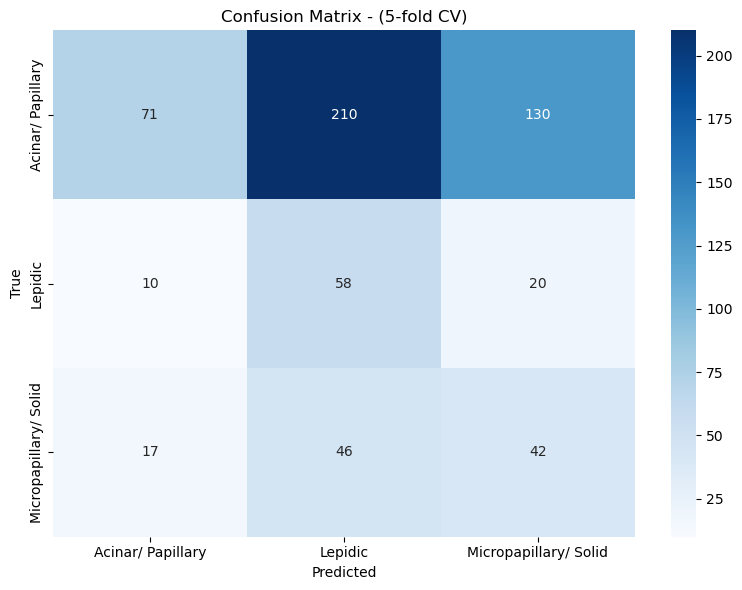

In [ ]:

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # sample_weight = compute_sample_weight(
    #     class_weight="balanced",
    #     y=y_train,
    # )


    # classifier.fit(X_train, y_train, sample_weight=sample_weight)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    acc = accuracy_score(y_test, y_pred)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    accuracies.append(acc)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# --- Print average results ---
print("Average over 5 folds:")
print(f"Precision (macro): {np.mean(precisions):.2f}")
print(f"Recall (macro):    {np.mean(recalls):.2f}")
print(f"F1-score (macro):  {np.mean(f1s):.2f}")
print(f"Accuracy:          {np.mean(accuracies):.2f}")

# --- Confusion matrix ---
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - (5-fold CV)")
plt.tight_layout()
plt.show()
